# **Deep Learning Assignment 1**

Danyang He (dh2914)

Jian Song (js5316)

**Problem 1 Fully connected network from scratch**

In [7]:

import torch, torchvision

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
import numpy as np
epsilon = 1e-8


Files already downloaded and verified
Files already downloaded and verified


In [0]:

class NeuralNetwork:
    def __init__(self, X, l, dimensions, alpha, beta=0.9, drop=0):
        self.layers = l
        self.A = []  # Output of each layer (0, 1, ..., self.layers -1 )
        self.Z = []  # Input of each layer (X, self.A[0:-2])
        self.w = []  # Weight (0, 1, ..., self.layers - 1)
        self.b = []  # Bias (0, 1, ..., self.layers - 1)
        self.drop = drop
        self.M = []  # List of dropout mask
        self.alpha = alpha  # learning rate
        self.vw = [] # parameter for momentum
        self.vb = [] # parameter for momentum
        self.beta = beta # parameter for momentum, usually 0.9
        for i in range(l):
            if i == 0:
                self.w.append(np.random.randn(X.shape[1], dimensions[i]) * np.sqrt(2 / (X.shape[1] + dimensions[i])))
                self.vw.append(np.zeros((X.shape[1], dimensions[i])))
            else:
                self.w.append(np.random.randn(dimensions[i - 1], dimensions[i]) * np.sqrt(2 / (dimensions[i - 1] + dimensions[i])))
                self.vw.append(np.zeros((dimensions[i - 1], dimensions[i])))
            self.b.append(np.zeros((1, dimensions[i])))
            self.vb.append(np.zeros((1, dimensions[i])))
        self.bn_params = {'running_mean': np.zeros(self.layers), 'running_var': np.zeros(self.layers), 'momentum': 0.9,
                          'eps': 1e-7}

    def affineForward(self, A, W, b):
        """
        :param A: input matrix of a layer
        :param W: weight matrix
        :param b: bias
        :returns: result of affine
        """
        return np.dot(A, W) + b

    def activationForward(self, Z):
        """
        :param Z: result after affine
        :returns: A
            WHERE
            A is matrix after applying relu
        """
        A = np.maximum(0, Z)
        return A

    def dropout(self, A, prob):
        """
        :param A: output value needs to do dropout
        :param prob: drop probability
        :returns: tuple (A, M)
            WHERE
            A is matrix after applying dropout
            M is dropout mask, will be used in the backward pass
        """
        M = np.random.uniform(size=A.shape)
        M = (M > prob) / (1 - prob)
        A = A * M
        return A, M

    def forwardPropagation(self, X):
        """
        :param X: input matrix
        :returns: Final output matrix (batch_size * num_classes), each row is a probability measure after softmax transformation
        For each layer except the last one, do affineforward and activationforward, append linear result and relu result to list self.Z and self.A respectively. And apply dropout at each output.
        In last layer, don't do relu, just do stable softmax 
        """
        y = X
        for i in range(self.layers):
            y = self.affineForward(y, self.w[i], self.b[i])
            self.Z.append(y)
            if i == self.layers - 1:
                y -= np.amax(y, axis=1).reshape(y.shape[0], 1)
                self.A.append(np.exp(y) / (np.sum(np.exp(y), axis=1).reshape(y.shape[0], 1)))
            else:
                # y = self.batchnorm_for_train(y, 0.2, 1, i, self.bn_params)
                y = self.activationForward(y)
                if self.drop > 0:
                    y, m = self.dropout(y, self.drop)
                    self.M.append(m)
                self.A.append(y)
        return np.exp(y) / (np.sum(np.exp(y), axis=1).reshape(y.shape[0], 1))

    # forwardpropagation for test : no dropout
    def forwardPropagation_test(self, X):
        y = X
        for i in range(self.layers):
            y = self.affineForward(y, self.w[i], self.b[i])
            if i == self.layers - 1:
                y -= np.amax(y, axis=1).reshape(y.shape[0], 1)
            else:
                # y = self.batchnorm_for_test(y, 0.2, 1, i, self.bn_params)
                y = self.activationForward(y)
        return np.exp(y) / np.sum(np.exp(y), axis=1).reshape(y.shape[0], 1)

    # calculate cross entropy
    def costFunction(self, y_train, y):
        log_likelihood = -np.log(y[range(y_train.shape[0]), y_train.reshape(y.shape[0], 1)])
        loss = np.sum(log_likelihood) / y_train.shape[1]
        return loss

    def affineBackward(self, dA_prev, A, w):
        """
        :param dA_prev: total derivative wrt to current Z
        :param A: non-linear output after previous layer
        :param w: weight matrix of previous affineforward
        :returns: dw, db, dAL
            WHERE dAL is the total derivative wrt to previous A
        """
        batch_size = dA_prev.shape[0]
        dAL = np.dot(dA_prev, w.T)
        dw = np.dot(A.T, dA_prev) / batch_size
        db = np.sum(dA_prev, axis=0) / batch_size
        return dAL, dw, db

    def activationBackward(self, Z, dA_prev):
        """
        :param X: input matrix
        :returns: Final output matrix (batch_size * num_classes), each row is a probability measure after softmax transformation
        For each layer except the last one, do affineforward and activationforward, append linear result and relu result to list self.Z and self.A respectively. And apply dropout at each output.
        In last layer, don't do relu, just do stable softmax 
        """
        dA_prev[np.nonzero(Z < 0)] = 0
        return dA_prev

    def dropout_backward(self, dA, m):
        """
        :param dA: previous derivative wrt to current A(not the last layer)
        :m: dropout mask
        :returns: derivative of dropout layer
        """
        return dA * m

    def backPropagation(self, dAL, X):
        """
        :param dAL: initial deriviate of L wrt A in the last layer
        :param X: input matrix
        Update w and b in each layer using function activationBackward and affineBackward
        """
        for l in range(self.layers - 1, -1, -1):
            if self.drop > 0 and l != self.layers - 1:
                dAL = self.dropout_backward(dAL, self.M[l])
            if l != self.layers - 1:
                dAL = self.activationBackward(self.Z[l], dAL)
            if l == 0:
                dAL, dw, db = self.affineBackward(dAL, X, self.w[0])
            else:
                dAL, dw, db = self.affineBackward(dAL, self.A[l - 1], self.w[l])

            self.updateParameters(dw, db, self.alpha, l)

    # Gradient descent with momentum
    def updateParameters(self, dw, db, alpha, layer):
        self.vw[layer] = self.beta * self.vw[layer] + (1 - self.beta) * dw
        self.vb[layer] = self.beta * self.vb[layer] + (1 - self.beta) * db
        self.w[layer] -= alpha * self.vw[layer]
        self.b[layer] -= alpha * self.vb[layer]

    def train(self, X_train, y_train, X_val, y_val, num_epochs, batch_size=128):
        for t in range(num_epochs):
            training_acc = 0
            chosen = np.random.randint(X_train.shape[0], size=batch_size)
            y_run = self.forwardPropagation(X_train[chosen,:])
            training_loss = self.costFunction(y_train[:, chosen], y_run)
            y_run[np.arange(batch_size), y_train[:, chosen]] -= 1
            dAL = y_run
            self.backPropagation(dAL, X_train[chosen,:])
            self.clear()
            y_train_predict = self.predict(X_train)
            training_acc = np.mean(y_train_predict == y_train)
            y_result = self.predict(X_val)
            if t % 100 == 0:
              print("Iterations: "+ str(t) + ": Training loss: {:.5}".format(training_loss) + " | Training accuracy: {:.5}".format(training_acc) + " | Validation accuracy: {:.5}".format(np.mean(y_result == y_val)))

        return training_loss / batch_size

    def predict(self, X_new):
        y = self.forwardPropagation_test(X_new)
        return np.argmax(y, axis=1)

    def clear(self):
        self.A = []
        self.Z = []
        self.M = []



In [0]:
import operator
import functools

d = functools.reduce(operator.mul, list(trainset[0][0].size()), 1)
X_train = np.zeros((len(trainset), d))
y_train = np.zeros((1, len(trainset)))
for i in range(len(trainset)):
    pixel = trainset[i][0].numpy()
    X_train[i, :] = pixel.flatten()
    y_train[0][i] = trainset[i][1]

In [0]:
   # split the data into training and validation set
   
def split(X, y, ratio):
    
    indices = np.random.permutation(X.shape[0])
    test_num = int(ratio * X.shape[0])
    return X[indices[test_num:], :], X[indices[:test_num], :], y[:, indices[test_num:]], y[:, indices[:test_num]]



In [10]:
nn = NeuralNetwork(X_train, 3, [512, 256, 10], 0.01, 0.9)
num_epochs = 500
y_train = y_train.astype(int)
X_train, X_val, y_train, y_val = split(X_train, y_train, 0.1)
nn.train(X_train, y_train, X_val, y_val, num_epochs, 4500)

Iterations: 0: Training loss: 2.5545 | Training accuracy: 0.11722 | Validation accuracy: 0.1154
Iterations: 100: Training loss: 2.7561 | Training accuracy: 0.31791 | Validation accuracy: 0.3176
Iterations: 200: Training loss: 2.5535 | Training accuracy: 0.36527 | Validation accuracy: 0.3662
Iterations: 300: Training loss: 3.4583 | Training accuracy: 0.39544 | Validation accuracy: 0.3962
Iterations: 400: Training loss: 2.9822 | Training accuracy: 0.41276 | Validation accuracy: 0.4142


0.0006431896023581424

In [12]:

num_epochs = 500
nn.train(X_train, y_train, X_val, y_val, num_epochs, 4500)

Iterations: 0: Training loss: 3.0952 | Training accuracy: 0.47027 | Validation accuracy: 0.4556
Iterations: 100: Training loss: 2.4351 | Training accuracy: 0.47704 | Validation accuracy: 0.4608
Iterations: 200: Training loss: 3.6255 | Training accuracy: 0.48264 | Validation accuracy: 0.4622
Iterations: 300: Training loss: 3.3322 | Training accuracy: 0.48858 | Validation accuracy: 0.4646
Iterations: 400: Training loss: 4.8675 | Training accuracy: 0.49387 | Validation accuracy: 0.4698


0.000801560372489013

In [13]:

num_epochs = 500
nn.train(X_train, y_train, X_val, y_val, num_epochs, 4500)

Iterations: 0: Training loss: 5.1232 | Training accuracy: 0.49896 | Validation accuracy: 0.4742
Iterations: 100: Training loss: 3.2103 | Training accuracy: 0.50416 | Validation accuracy: 0.4796
Iterations: 200: Training loss: 2.5239 | Training accuracy: 0.50909 | Validation accuracy: 0.483
Iterations: 300: Training loss: 3.0364 | Training accuracy: 0.51264 | Validation accuracy: 0.485
Iterations: 400: Training loss: 2.8885 | Training accuracy: 0.51664 | Validation accuracy: 0.4852


0.0006139823645637087

In [14]:

num_epochs = 500
nn.train(X_train, y_train, X_val, y_val, num_epochs, 4500)

Iterations: 0: Training loss: 3.0404 | Training accuracy: 0.52107 | Validation accuracy: 0.4894
Iterations: 100: Training loss: 3.8179 | Training accuracy: 0.52613 | Validation accuracy: 0.4902
Iterations: 200: Training loss: 3.7131 | Training accuracy: 0.52998 | Validation accuracy: 0.4938
Iterations: 300: Training loss: 4.7321 | Training accuracy: 0.53404 | Validation accuracy: 0.4944
Iterations: 400: Training loss: 2.3688 | Training accuracy: 0.53791 | Validation accuracy: 0.498


0.000589103871267081

In [15]:

num_epochs = 500
nn.train(X_train, y_train, X_val, y_val, num_epochs, 4500)

Iterations: 0: Training loss: 3.1035 | Training accuracy: 0.54202 | Validation accuracy: 0.499
Iterations: 100: Training loss: 3.5503 | Training accuracy: 0.54622 | Validation accuracy: 0.5002
Iterations: 200: Training loss: 2.739 | Training accuracy: 0.55056 | Validation accuracy: 0.5026
Iterations: 300: Training loss: 3.8994 | Training accuracy: 0.55453 | Validation accuracy: 0.5038
Iterations: 400: Training loss: 4.2156 | Training accuracy: 0.55811 | Validation accuracy: 0.505


0.0008255766722854919

In [0]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5# unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [0]:
X_test = np.zeros((len(testset), d))
y_test = np.zeros((1, len(testset)))
for i in range(len(testset)):
    pixel = testset[i][0].numpy()
    X_test[i, :] = pixel.flatten()
    y_test[0][i] = testset[i][1]


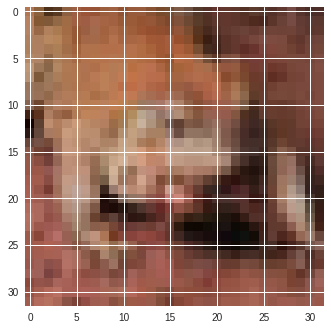

6 frog
6


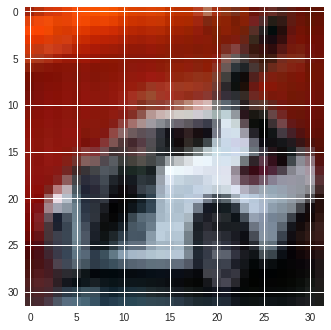

1 automobile
3


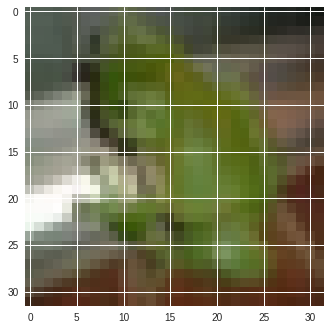

6 frog
6


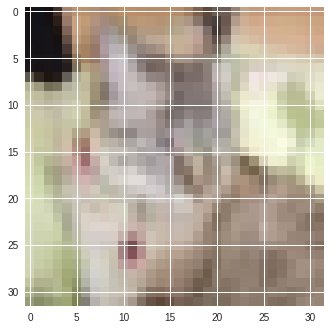

3 cat
5


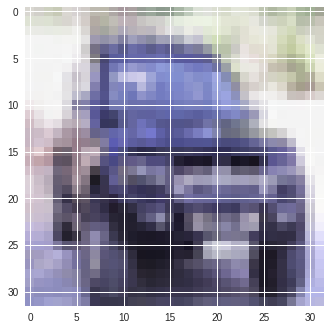

1 automobile
1


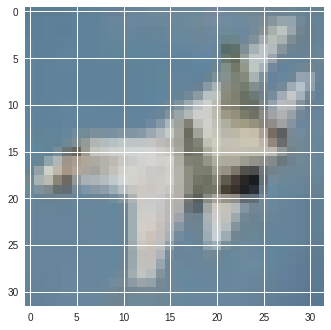

0 airplane
8


In [20]:

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
y_result = nn.predict(X_test)
for i in range(5, 11, 1):
  imshow(testset[i][0])
  print(testset[i][1], classes[testset[i][1]])
  print(y_result[i])

From the above images, we can see our model can correctly classify some images although the performance is not perfect.

**Problem 2 CNN using Pytorch**

Here is our **baseline model.** We used two convolution layers with kernel size 5(increasing channel to 64 ), normalization layer and pool layer.  After that, we append three fully connected network. We can see the result can easily hit above 70% validation accuracy. So we cut our epochs to just 20 times.

In [4]:
import torch, torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
train_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
test_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transformations)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

In [0]:
# Import needed packages
import torch
import torch.nn as nn

class BaseLineNet(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseLineNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        
        self.pool = nn.MaxPool2d(2, 2)
        
        
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.norm2 = nn.BatchNorm2d(64)
        
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)


    def forward(self, input):
        output = self.conv1(input)
        output = self.norm1(output)
        output = self.relu(output)
        
        output = self.pool(output)
        
        output = self.conv2(output)
        output = self.norm2(output)
        output = self.relu(output)
        
        output = self.pool(output)
        
        output = output.view(-1, 64 * 5 * 5)
        
        output = self.fc1(output)
        output = self.relu(output)
        
        output = self.fc2(output)
        output = self.relu(output)
        
        output = self.fc3(output)
        return output

In [0]:
from torch.optim import Adam, SGD
# Check if gpu support is available
cuda_avail = torch.cuda.is_available()
model = BaseLineNet(num_classes=10)

#if cuda is available, move the model to the GPU
if cuda_avail:
    model.cuda()

# using Adam is better than sgd
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [0]:
def test(path):
    model = SimpleNet(num_classes=10)
    model.load_state_dict(torch.load(path))
    model.cuda()
    
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):

        if cuda_avail:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        # Predict labels using images from the test set
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        
        test_acc += torch.sum(prediction == labels.data)
        
    # average test accuracy
    test_acc = float(test_acc) / 10000
    
    return test_acc

In [0]:

# Automatically adjust learning rate(decrement by 10 every 30 epochs)
def adjust_learning_rate(epoch):
    lr = 0.001
    
    if epoch > 90:
        lr = lr / 1000
    elif epoch > 60:
        lr = lr / 100
    elif epoch > 30:
        lr = lr / 10

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [0]:
from torch.autograd import Variable
def train(num_epochs):
  
    #Create a loder for the training set
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transformations)
    trainset, valset = torch.utils.data.random_split(trainvalset, [45000, 5000])
    train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
    val_loader = DataLoader(valset, batch_size=128, shuffle=True, num_workers=4)
    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch + 1, num_epochs))
      print('-' * 100)
      model.train()
      train_acc = 0.0
      train_loss = 0.0
      val_acc = 0.0
      val_loss = 0.0
      for i, (images, labels) in enumerate(train_loader):
          
          # Move images and labels to gpu if available
          if cuda_avail:
              images = Variable(images.cuda())
              labels = Variable(labels.cuda())

          # Clear all accumulated gradients
          optimizer.zero_grad()
          # See how it performs currently on training data
          outputs = model(images)
          
          loss = loss_fn(outputs, labels)
          
          loss.backward()

          # Adjust parameters according to the computed gradients
          optimizer.step()
      
          train_loss += loss.item() * images.size(0)
          _, prediction = torch.max(outputs.data, 1)
            
          train_acc += torch.sum(prediction == labels.data)
            
      model.eval()
      for i, (images, labels) in enumerate(val_loader):
          if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

          # Test on validation data
          outputs = model(images)
          
          loss = loss_fn(outputs, labels)
            
          val_loss += loss.item() * images.size(0)
          _, prediction = torch.max(outputs.data, 1)
            
          val_acc += torch.sum(prediction == labels.data)
            
      # Ajust learning rate 
      adjust_learning_rate(epoch)

      # Compute the average acc and loss over training set and validation set
      train_acc = float(train_acc) / 45000
      val_acc = float(val_acc) / 5000
      train_loss = float(train_loss) / 50000
      val_loss = float(val_loss)/ 50000

      print("Epoch {}, Train Accuracy: {} , Validation Accuracy: {} , TrainLoss: {} , ValiLoss: {}, ".format(epoch + 1, train_acc, val_acc, train_loss, val_loss))

        

In [45]:
if __name__ == "__main__":
    train(20)
    
   

Files already downloaded and verified
Epoch 1/20
----------------------------------------------------------------------------------------------------
Epoch 1, Train Accuracy: 0.9127111111111111 , Validation Accuracy: 0.9004 , TrainLoss: 0.2452009422326088 , ValiLoss: 0.031389060697555544, 
Epoch 2/20
----------------------------------------------------------------------------------------------------
Epoch 2, Train Accuracy: 0.9304222222222223 , Validation Accuracy: 0.8906 , TrainLoss: 0.1909951001763344 , ValiLoss: 0.035589414110183716, 
Epoch 3/20
----------------------------------------------------------------------------------------------------
Epoch 3, Train Accuracy: 0.9395555555555556 , Validation Accuracy: 0.8856 , TrainLoss: 0.16019406205177308 , ValiLoss: 0.03604602836608887, 
Epoch 4/20
----------------------------------------------------------------------------------------------------
Epoch 4, Train Accuracy: 0.9444444444444444 , Validation Accuracy: 0.8786 , TrainLoss: 0.14

We tried to build a network that contains 4 convolution layers, each with one normalization layer and three fully connected layers. After the second and the fourth convolution layer, we add dropout layer. And after the final fully connected layer, we use softmax to transform the output into probability space. Details are commented in the code. The result for this architecture was good, training accuracy hitting 90.4% and validation accuracy easily staying higher than 70%(at around 72% on average). (but it was hard for validation accuracy to go higher)

In [0]:

# Import needed packages
import torch
import torch.nn as nn


class SimpleNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleNet, self).__init__()
        
        # increase channel to 32 : 3 * 32 * 32 -> 32 * 32 * 32
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.norm = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
    
        # half the image size: 32 * 32 * 32 -> 32 * 16 * 16
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # increase channel to 64: 32 * 16 * 16 -> 64 * 16 * 16
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        
        # half the image size: 64 * 16 * 16 -> 64 * 8 * 8
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # increase channel to 128: 64 * 8 * 8 -> 128 * 8 * 8
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.norm3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        
        # half the image size: 128 * 8 * 8 -> 128 * 4 * 4
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # increase channel to 128: 128 * 4 * 4 -> 256 * 4 * 4
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.norm4 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU()
        
        
        self.dropout = nn.Dropout(0.5)  # drop 50% of the neuron
        
        self.fc1 = nn.Linear(in_features=8 * 8 * 64, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        self.softmax = nn.Softmax(dim=1)
        
        setattr(self, 'final', self.norm)
        setattr(self, 'final2', self.norm2)
        setattr(self, 'final3', self.norm3)
        setattr(self, 'final4', self.norm4)

    def forward(self, input):
        output = self.conv1(input)
        output = self.norm(output)
        output = self.relu(output)

        output = self.pool(output)
        
        output = self.conv2(output)
        output = self.norm2(output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.pool2(output)
        
        output = self.conv3(output)
        output = self.norm3(output)
        output = self.relu(output)

        output = self.pool3(output)
        
        output = self.conv4(output)
        output = self.norm4(output)
        output = self.relu(output)
        output = self.dropout(output)

        # reshape the input for the linear neuron
        output = output.view(-1, 8 * 8 * 64)

        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        output = self.relu(output)
        output = self.fc3(output)
        output = self.softmax(output)
        return output

In [0]:
from torch.optim import Adam, SGD
# Check if gpu support is available
cuda_avail = torch.cuda.is_available()
model = SimpleNet(num_classes=10)

#if cuda is available, move the model to the GPU
if cuda_avail:
    model.cuda()

# using Adam is better than sgd
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [0]:
def test(path):
    model = SimpleNet(num_classes=10)
    model.load_state_dict(torch.load(path))
    model.cuda()
    
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):

        if cuda_avail:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        # Predict labels using images from the test set
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        
        test_acc += torch.sum(prediction == labels.data)
        
    # average test accuracy
    test_acc = float(test_acc) / 10000
    
    return test_acc

In [0]:

# Automatically adjust learning rate(decrement by 10 every 30 epochs)
def adjust_learning_rate(epoch):
    lr = 0.001
    
    if epoch > 90:
        lr = lr / 1000
    elif epoch > 60:
        lr = lr / 100
    elif epoch > 30:
        lr = lr / 10

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [0]:
from torch.autograd import Variable
def train(num_epochs):
  
    #Create a loder for the training set
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transformations)
    trainset, valset = torch.utils.data.random_split(trainvalset, [45000, 5000])
    train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
    val_loader = DataLoader(valset, batch_size=128, shuffle=True, num_workers=4)
    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch + 1, num_epochs))
      print('-' * 100)
      model.train()
      train_acc = 0.0
      train_loss = 0.0
      val_acc = 0.0
      val_loss = 0.0
      for i, (images, labels) in enumerate(train_loader):
          
          # Move images and labels to gpu if available
          if cuda_avail:
              images = Variable(images.cuda())
              labels = Variable(labels.cuda())

          # Clear all accumulated gradients
          optimizer.zero_grad()
          # See how it performs currently on training data
          outputs = model(images)
          
          loss = loss_fn(outputs, labels)
          
          loss.backward()

          # Adjust parameters according to the computed gradients
          optimizer.step()
      
          train_loss += loss.item() * images.size(0)
          _, prediction = torch.max(outputs.data, 1)
            
          train_acc += torch.sum(prediction == labels.data)
            
      model.eval()
      for i, (images, labels) in enumerate(val_loader):
          if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

          # Test on validation data
          outputs = model(images)
          
          loss = loss_fn(outputs, labels)
            
          val_loss += loss.item() * images.size(0)
          _, prediction = torch.max(outputs.data, 1)
            
          val_acc += torch.sum(prediction == labels.data)
            
      # Ajust learning rate 
      adjust_learning_rate(epoch)

      # Compute the average acc and loss over training set and validation set
      train_acc = float(train_acc) / 45000
      val_acc = float(val_acc) / 5000
      train_loss = float(train_loss) / 50000
      val_loss = float(val_loss)/ 50000

      print("Epoch {}, Train Accuracy: {} , Validation Accuracy: {} , TrainLoss: {} , ValiLoss: {}, ".format(epoch + 1, train_acc, val_acc, train_loss, val_loss))

        

In [14]:
if __name__ == "__main__":
    train(100)
    
   

Files already downloaded and verified
Epoch 1/100
----------------------------------------------------------------------------------------------------
Epoch 1, Train Accuracy: 0.4429111111111111 , Validation Accuracy: 0.2998 , TrainLoss: 1.8129285558891297 , ValiLoss: 0.21456717193603517, 
Epoch 2/100
----------------------------------------------------------------------------------------------------
Epoch 2, Train Accuracy: 0.5642 , Validation Accuracy: 0.3862 , TrainLoss: 1.705213528690338 , ValiLoss: 0.20670979549407958, 
Epoch 3/100
----------------------------------------------------------------------------------------------------
Epoch 3, Train Accuracy: 0.6099333333333333 , Validation Accuracy: 0.4384 , TrainLoss: 1.6634429684638976 , ValiLoss: 0.20181866706848145, 
Epoch 4/100
----------------------------------------------------------------------------------------------------
Epoch 4, Train Accuracy: 0.6428444444444444 , Validation Accuracy: 0.3946 , TrainLoss: 1.63553725063323

In [15]:
def save_models():
    torch.save(model.state_dict(), "SimpleAdamWithNormDropout")
    print("Chekcpoint saved")
save_models() #Adam
test("SimpleAdamWithNormDropout")
  

Chekcpoint saved


0.7258

In [0]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
  img = img / 2 + 0.5# unnormalize
  npimg = img.cpu().numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
 

In [0]:
  import matplotlib.pyplot as plt
  import numpy as np
  def imshow(img):
    img = img / 2 + 0.5# unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

  def predict(path, img, label):
    model = SimpleNet(num_classes=10)
    model.load_state_dict(torch.load(path))
    model.cuda()
    
    model.eval()
    test_acc = 0.0
    
    if cuda_avail:
        img = Variable(img.cuda())
    outputs = model(img)
    _, prediction = torch.max(outputs.data, 1)
        
    print(type(prediction[0]))
    print(prediction[0], label, classes[label])
    imshow(img[0, :, :, :])
    plt.show()

<class 'torch.Tensor'>
tensor(6, device='cuda:0') 6 frog


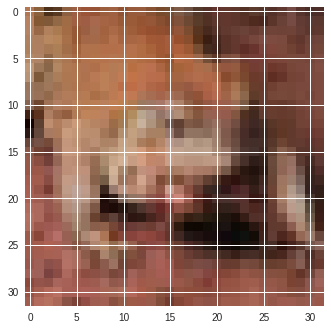

<class 'torch.Tensor'>
tensor(6, device='cuda:0') 6 frog


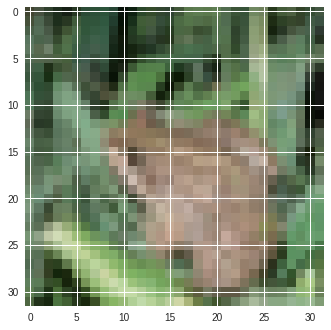

<class 'torch.Tensor'>
tensor(0, device='cuda:0') 0 airplane


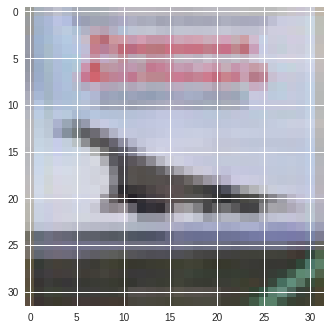

<class 'torch.Tensor'>
tensor(8, device='cuda:0') 8 ship


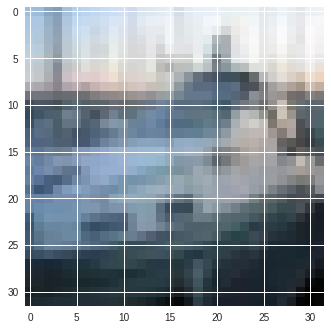

<class 'torch.Tensor'>
tensor(8, device='cuda:0') 8 ship


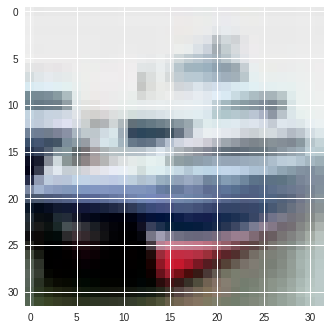

<class 'torch.Tensor'>
tensor(3, device='cuda:0') 3 cat


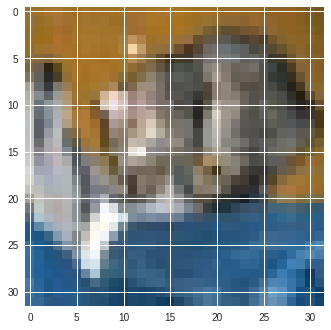

In [24]:

  classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
 
  predict("SimpleAdamWithNormDropout" , testset[5][0].view(1, 3, 32 ,32), testset[5][1])
  predict("SimpleAdamWithNormDropout" , testset[4][0].view(1, 3, 32 ,32), testset[4][1])
  predict("SimpleAdamWithNormDropout" , testset[3][0].view(1, 3, 32 ,32), testset[3][1])
  predict("SimpleAdamWithNormDropout" , testset[2][0].view(1, 3, 32 ,32), testset[2][1])
  predict("SimpleAdamWithNormDropout" , testset[1][0].view(1, 3, 32 ,32), testset[1][1])
  predict("SimpleAdamWithNormDropout" , testset[0][0].view(1, 3, 32 ,32), testset[0][1])

In [1]:
import torch, torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
train_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
test_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transformations)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

Files already downloaded and verified


Accordingg to previous result, we think stacking too many layers may not help in proving validation accuray. So in this model, we maintain only three convolution layer and one max pool layer after the first convolution layer.  And change the kernel size to 5. Plus, we also remove the last fc layer. Detailed model is commented in code. 

The result for this model is good, training accuracy at around 80% while validation accuracy is 73% on average(higher than our previous one). Although losing some training accuracy, the validation is more acceptable.

In [0]:

# Import needed packages
import torch
import torch.nn as nn


class DifferentNet(nn.Module):
    def __init__(self, num_classes=10):
        super(DifferentNet, self).__init__()
        
        # 3 * 32 * 32 -> 32 * 30 * 30
        self.conv1 = nn.Conv2d(3, 32, 5, padding=1, stride=1)
        self.norm = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()

        # pool layer with kernel size 2: 32 * 30 * 30 -> 32 * 15 * 15
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # 32 * 15 * 15 -> 64 * 7 * 7
        self.conv2 = nn.Conv2d(32, 64, 5, padding=1, stride=2)
        self.norm2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # 64 * 8 * 8 -> 128 * 5 * 5
        self.conv3 = nn.Conv2d(64, 128, 5, padding=1)
        self.norm3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.5)  # drop 50% of the neuron
        
        self.fc1 = nn.Linear(in_features=128 * 5 * 5, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=10)
        self.softmax = nn.Softmax(dim=1)
        
        setattr(self, 'final', self.norm)
        setattr(self, 'final2', self.norm2)
        setattr(self, 'final3', self.norm3)

    def forward(self, input):
        output = self.conv1(input)
        output = self.norm(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.pool(output)
        
        output = self.conv2(output)
        output = self.norm2(output)
        output = self.relu(output)
        output = self.dropout(output)
        
        output = self.conv3(output)
        output = self.norm3(output)
        output = self.relu(output)
        output = self.dropout(output)
        
        # reshape tensor
        output = output.view(-1, 128 * 5 * 5)

        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        output = self.softmax(output)
        
        return output

In [0]:
from torch.autograd import Variable
def train(num_epochs):
  
    #Create a loder for the training set
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transformations)
    trainset, valset = torch.utils.data.random_split(trainvalset, [45000, 5000])
    train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
    val_loader = DataLoader(valset, batch_size=128, shuffle=True, num_workers=4)
    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch + 1, num_epochs))
      print('-' * 100)
      model.train()
      train_acc = 0.0
      train_loss = 0.0
      val_acc = 0.0
      val_loss = 0.0
      for i, (images, labels) in enumerate(train_loader):
          
          # Move images and labels to gpu if available
          if cuda_avail:
              images = Variable(images.cuda())
              labels = Variable(labels.cuda())

          # Clear all accumulated gradients
          optimizer.zero_grad()
            # Predict classes using images from the test set
          outputs = model(images)
            # Compute the loss based on the predictions and actual labels
          loss = loss_fn(outputs, labels)
            # Backpropagate the loss
          loss.backward()

            # Adjust parameters according to the computed gradients
          optimizer.step()
      
          train_loss += loss.item() * images.size(0)
          _, prediction = torch.max(outputs.data, 1)
            
          train_acc += torch.sum(prediction == labels.data)
            
      model.eval()
      for i, (images, labels) in enumerate(val_loader):
          if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

          outputs = model(images)
          
          loss = loss_fn(outputs, labels)
            
          val_loss += loss.item() * images.size(0)
          _, prediction = torch.max(outputs.data, 1)
            
          val_acc += torch.sum(prediction == labels.data)
            
        # Call the learning rate adjustment function
      adjust_learning_rate(epoch)

        # Compute the average acc and loss over training set and validation set
      train_acc = float(train_acc) / 45000
      val_acc = float(val_acc) / 5000
      train_loss = float(train_loss) / 50000
      val_loss = float(val_loss)/ 50000

      print("Epoch {}, Train Accuracy: {} , Validation Accuracy: {} , TrainLoss: {} , ValiLoss: {}, ".format(epoch + 1, train_acc, val_acc, train_loss, val_loss))

        

In [0]:
from torch.optim import Adam, SGD
# Check if gpu support is available
cuda_avail = torch.cuda.is_available()

# Create model, optimizer and loss function
model = DifferentNet(num_classes=10)

#if cuda is available, move the model to the GPU
if cuda_avail:
    model.cuda()

#Define the optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [12]:
if __name__ == "__main__":
    train(100)

Files already downloaded and verified
Epoch 1/100
----------------------------------------------------------------------------------------------------
Epoch 1, Train Accuracy: 0.5157777777777778 , Validation Accuracy: 0.5076 , TrainLoss: 1.7486761983489991 , ValiLoss: 0.19497733604431153, 
Epoch 2/100
----------------------------------------------------------------------------------------------------
Epoch 2, Train Accuracy: 0.5555111111111111 , Validation Accuracy: 0.4848 , TrainLoss: 1.7132833312606812 , ValiLoss: 0.19701893854141236, 
Epoch 3/100
----------------------------------------------------------------------------------------------------
Epoch 3, Train Accuracy: 0.5815777777777777 , Validation Accuracy: 0.5458 , TrainLoss: 1.689544693584442 , ValiLoss: 0.19155294038772583, 
Epoch 4/100
----------------------------------------------------------------------------------------------------
Epoch 4, Train Accuracy: 0.6014 , Validation Accuracy: 0.572 , TrainLoss: 1.670745350322723

In [0]:
def test(path):
    model = DifferentNet(num_classes=10)
    model.load_state_dict(torch.load(path))
    model.cuda()
    
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):

        if cuda_avail:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        # Predict classes using images from the test set
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        
        test_acc += torch.sum(prediction == labels.data)
#         imshow(images)
    # Compute the average acc and loss over all 10000 test images
    test_acc = float(test_acc) / 10000
    
    return test_acc

In [14]:
def save_models():
    torch.save(model.state_dict(), "SimpleAdam2")
    print("Chekcpoint saved")
save_models() #Augmentation
test("SimpleAdam2")

Chekcpoint saved


0.7355

In [0]:
def predict(path, img, label):
    model = DifferentNet(num_classes=10)
    model.load_state_dict(torch.load(path))
    model.cuda()
    
    model.eval()
    test_acc = 0.0
    
    if cuda_avail:
        img = Variable(img.cuda())
    outputs = model(img)
    _, prediction = torch.max(outputs.data, 1)
        
    print(type(prediction[0]))
    print(prediction[0], label, classes[label])
    imshow(img[0, :, :, :])
    plt.show()
  

<class 'torch.Tensor'>
tensor(6, device='cuda:0') 6 frog


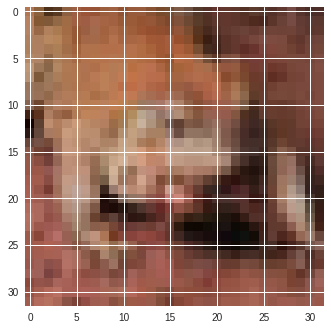

<class 'torch.Tensor'>
tensor(6, device='cuda:0') 6 frog


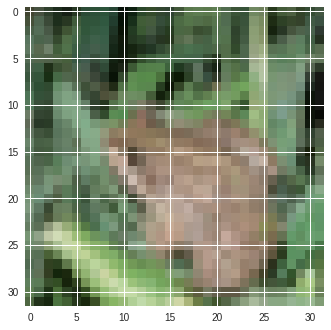

<class 'torch.Tensor'>
tensor(0, device='cuda:0') 0 airplane


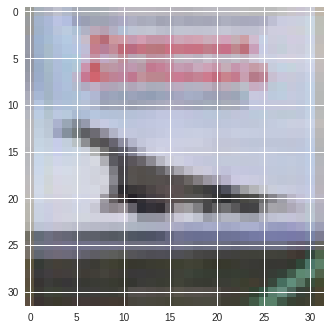

<class 'torch.Tensor'>
tensor(8, device='cuda:0') 8 ship


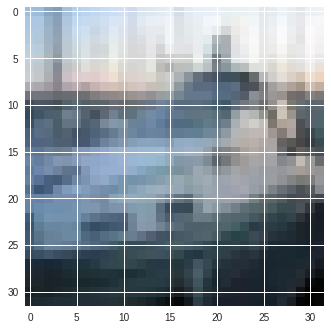

<class 'torch.Tensor'>
tensor(8, device='cuda:0') 8 ship


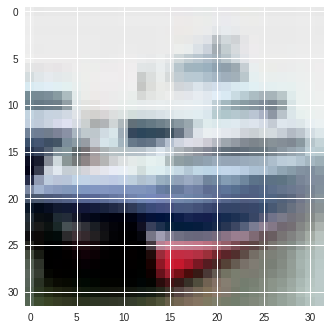

<class 'torch.Tensor'>
tensor(3, device='cuda:0') 3 cat


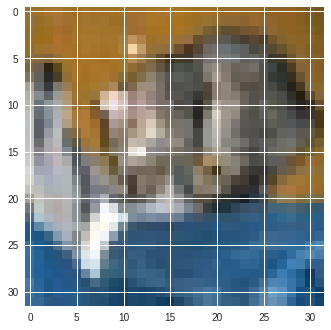

In [22]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
 
predict("SimpleAdam2" , testset[5][0].view(1, 3, 32 ,32), testset[5][1])
predict("SimpleAdam2" , testset[4][0].view(1, 3, 32 ,32), testset[4][1])
predict("SimpleAdam2" , testset[3][0].view(1, 3, 32 ,32), testset[3][1])
predict("SimpleAdam2" , testset[2][0].view(1, 3, 32 ,32), testset[2][1])
predict("SimpleAdam2" , testset[1][0].view(1, 3, 32 ,32), testset[1][1])
predict("SimpleAdam2" , testset[0][0].view(1, 3, 32 ,32), testset[0][1])